Image registration tool using cv2  

Possible future features:
* Preprocess image if needed (e.g. invert pixel value)
* change sift parameters
* Iterating over Lowe's Ratio Test - Maybe values between 0.6-0.8 - lower is more selective.
* Change RANSAC reprojection threshold - a smaller value will increase precision (fewer incorrect matches will be accepted), but may also decrease recall (fewer total matches will be found).
* Use metrixs to evaluate registration matrix.
* Maybe change the random seed to get better registration results (and loop)

In [1]:
import argparse
import cv2
import numpy as np
import os
import logging
from enum import Enum
import sys
from glob import glob
try:
    import tifffile as tif
except ImportError(tif):
    logging.warning("tif images can't be read, as the tifffile package is not installed.")
try:
    import aicspylibczi
except ImportError(aicspylibczi):
    logging.warning("CZI images can't be read, as the aicspylibczi package is not installed.")

In [34]:
def def_flann_matches():
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    return flann

In [35]:
class RuntimeParameters(Enum):
    cv2_warp_max_image_size = 32767
    cv2_seed = 0
    sift = cv2.SIFT_create()
    flann = def_flann_matches()

In [2]:
def set_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logging.info("Starting")

In [42]:
def get_list_of_source_images_paths(src_img_or_dir_path, dst_img_path):
    if os.path.isdir(src_img_or_dir_path):
        src_ims_paths = [f for f in glob(os.path.join(src_img_or_dir_path, '*')) if
                         os.path.basename(f) != os.path.basename(dst_img_path)]
    else:
        src_ims_paths = [src_img_or_dir_path]

    src_ims_paths_str = "\n" + "\n".join(src_ims_paths)
    logging.info(f'List of images to register to destination image: {src_ims_paths_str}')

    return src_ims_paths

In [3]:
def get_file_extension(image_path):
    return os.path.splitext(image_path)[-1]

In [4]:
def read_and_preprocess_destination_image(dst_img_path, dst_extension, cnl_for_sift_analysis):
    logging.info(f'Reading destination image:')
    image = read_and_preprocess_image(dst_img_path, dst_extension, cnl_for_sift_analysis)

    if image is None:
        raise Exception('Destination image path is either not an image or an unsupported format.')

    return image

In [5]:
def read_and_preprocess_image(image_path, extension, cnl_for_sift_analysis):
    logging.info(f'Reading image {image_path}')

    image = read_image(image_path, extension, cnl_for_sift_analysis)
    if image is not None:
        image = preprocess_image(image)

    return image

In [6]:
def read_image(image_path, extension, channel_idx=0):
    if extension == '.tif':
        image = tif.imread(image_path, key=channel_idx)
    elif extension == '.czi':
        czi = read_czi(image_path)
        image = read_czi_image(czi, channel_idx=channel_idx)
    else:
        image = cv2.imread(image_path)

    if image is None:
        logging.warning(f'Source {image_path} either not an image file or unsupported format - Skipping')
        return None

    logging.info(f'Read {image_path}, Channel: {channel_idx}, image shape: {image.shape}')
    log_image_metadata(image, is_preprocessed=False)

    return image

In [7]:
def read_czi(image_path):
    czi = aicspylibczi.CziFile(image_path)
    # log_czi_metadata(czi)
    return czi


In [8]:
def read_czi_image(czi, channel_idx=0):
    # need to have scale_factor as parameter - scale_factor=0.25
    full_channel = czi.read_mosaic(C=channel_idx)[0]
    return full_channel


In [9]:
def preprocess_image(image):
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # image = cv2.equalizeHist(image)

    log_image_metadata(image)

    return image

In [10]:
def log_image_metadata(image, is_preprocessed=True):
    processed_str = ' after preprocessing' if is_preprocessed else ''

    logging.info(f'image shape{processed_str}: {image.shape}')
    logging.info(f'image data type{processed_str}: {image.dtype}')
    logging.info(f'image range{processed_str}: {np.min(image), np.max(image)}')

In [11]:
def create_output_dir(out_path, dst_img, dst_img_path):
    os.makedirs(out_path, exist_ok=True)
    cv2.imwrite(os.path.join(out_path, f'forViewing_{os.path.basename(dst_img_path)}__destination_image.png'), dst_img)


In [12]:
def get_sift_based_transformation_matrix(src_img, dst_img, tile_size_tuple, tile_overlap):
    kp1, des1 = compute_sift_tiles(src_img,
                                   tile_size_tuple,
                                   tile_overlap,
                                   RuntimeParameters.sift.value)
    kp2, des2 = compute_sift_tiles(dst_img,
                                   tile_size_tuple,
                                   tile_overlap,
                                   RuntimeParameters.sift.value)

    logging.info('DONE: sift based key-points detection and descriptors computation')

    matches = RuntimeParameters.flann.value.knnMatch(des1, des2, k=2)
    logging.info('DONE: FLANN - Fast Library for Approximate Nearest Neighbors - descriptor matching')

    good_matches = get_good_matches(matches)
    logging.info('DONE: get good matches by distance thresholding')

    src_pts, dst_pts = get_pts_from_matches(good_matches, kp1, kp2)
    # plot_good_matches(src_img, dst_img, src_pts, dst_pts)

    h, msk = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    logging.info('DONE: calculated homography matrix')

    return h, msk, src_pts, dst_pts


In [13]:
def get_pts_from_matches(good_matches, kp1, kp2):
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    else:
        raise AssertionError("Not enough matches found for image registration.")

    return src_pts, dst_pts

In [14]:
def get_good_matches(matches):
    # Store all the good matches using Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good_matches.append(m)

    return good_matches


In [15]:
def compute_sift_tiles(image, tile_size_tuple, tile_overlap, sift):
    key_points = []
    descriptors = []

    h, w = image.shape

    # Extend the image so that it can be divided into equal size tiles
    h_extend = ((h - 1) // (tile_size_tuple[1] - tile_overlap) + 1) * (tile_size_tuple[1] - tile_overlap) + tile_overlap
    w_extend = ((w - 1) // (tile_size_tuple[0] - tile_overlap) + 1) * (tile_size_tuple[0] - tile_overlap) + tile_overlap

    image_extended = np.zeros((h_extend, w_extend), dtype=image.dtype)

    image_extended[:h, :w] = image

    for y in range(0, h_extend - tile_overlap, tile_size_tuple[1] - tile_overlap):
        for x in range(0, w_extend - tile_overlap, tile_size_tuple[0] - tile_overlap):
            tile = image_extended[y:y + tile_size_tuple[1], x:x + tile_size_tuple[0]]
            kp_tile, des_tile = sift.detectAndCompute(tile, None)

            # Adjust keypoint positions to global image coordinates
            for kp in kp_tile:
                kp.pt = (kp.pt[0] + x, kp.pt[1] + y)

            key_points.extend(kp_tile)
            if des_tile is not None:
                descriptors.extend(des_tile)

    return key_points, np.array(descriptors)

In [16]:
def save_h(out_path, h, src_img_path):
    np.save(os.path.join(out_path, f'{os.path.basename(src_img_path)}__registration_matrix.npy'), h)


In [17]:
def warp_image(dst_img_shape, src_img, h):
    if max(src_img.shape) < RuntimeParameters.cv2_warp_max_image_size.value \
            and max(dst_img_shape) < RuntimeParameters.cv2_warp_max_image_size.value:
        registered_img = cv2.warpPerspective(src_img, h, dst_img_shape[::-1])
    else:
        registered_img = warp_using_skimage(dst_img_shape, src_img, h)

    logging.info('Registered image')

    return registered_img

In [18]:
def warp_using_skimage(dst_img_shape, src_img, h):
    try:
        import skimage.transform
    except ImportError:
        logging.warning(
            "Images width/height is larger than 32767 - Please install skimage and rerun -" +
            " due to cv2 warp function limitation.")
        raise AssertionError("Not enough matches found for image registration.")

    h_inv = np.linalg.inv(h)
    registered_img = skimage.transform.warp(src_img, h_inv, output_shape=dst_img_shape,
                                            preserve_range=True).astype(src_img.dtype)

    return registered_img


In [19]:
def check_transformation_metrics(src_pts, dst_pts, h, msk, src_img, dst_img, registered_img):
    # HOW DO I HANDLE THOSE CASES?
    if check_degenerate(src_pts) or check_degenerate(dst_pts):
        logging.warning("Degenerate keypoint configuration detected! Might result in a faulty homography matrix!!")

    check_transformation_by_pts_mean_sqrt(src_pts, dst_pts, h, msk)
    check_transformation_by_n_inliers(msk)
    check_transformation_by_point_distribution(h, src_img)
    check_transformation_by_joint_entropy(registered_img, dst_img)
    check_transformation_by_mse(registered_img, dst_img)

In [20]:
def check_degenerate(points):
    # Compute the standard deviation of the points
    std_dev = np.std(points, axis=0)

    # If the standard deviation is below a threshold (here 1.0),
    # it might indicate that the points are in a degenerate configuration.
    if np.any(std_dev < 1.0):
        logging.warning("Warning: points may be in a degenerate configuration.")

In [21]:
def check_transformation_by_pts_mean_sqrt(src_pts, dst_pts, h, msk):
    # Map the key_points in the source image to the destination image using the homography
    mapped_src_pts = cv2.perspectiveTransform(src_pts, h)
    # Calculate the Euclidean distances between the mapped source key_points and the destination key_points
    distances = np.sqrt(np.sum((mapped_src_pts - dst_pts) ** 2, axis=2))
    inlier_distances = distances[msk == 1]
    # Calculate the mean of the distances
    mean_distance = np.mean(inlier_distances)

    logging.info(f'Mean Euclidean distance of mapped source key-points and destination key-points: {mean_distance}')

    return mean_distance

In [22]:
def check_transformation_by_n_inliers(msk):
    # Convert mask to a list
    msk = msk.ravel().tolist()

    # Count the number of inliers and outliers
    n_inliers = msk.count(1)
    n_outliers = msk.count(0)

    logging.info(f'RANSAC number of Inliers: {n_inliers}')
    logging.info(f'RANSAC number of Outliers: {n_outliers}')

In [23]:
def check_transformation_by_point_distribution(h, src_img):
    # Create a grid of points in the source image
    height, width = src_img.shape
    x = np.linspace(0, width, num=50)
    y = np.linspace(0, height, num=50)
    xv, yv = np.meshgrid(x, y)
    points = np.column_stack([xv.ravel(), yv.ravel()])

    # Transform the points using the homography
    points_t = cv2.perspectiveTransform(points.reshape(-1, 1, 2), h)

    # Compute the standard deviation of the transformed points
    std_dev = np.std(points_t, axis=0)

    # If the standard deviation is very small or very large, it might indicate a poor transformation.
    if np.any(std_dev < 1.0) or np.any(std_dev > max(height, width)):
        logging.warning("Transformation may be poor - transformed points grid seem to be concentrated!")


In [24]:
def check_transformation_by_joint_entropy(image1, image2, bins=256):
    try:
        from scipy.stats import entropy
    except ImportError:
        logging.warning("Joint entropy won't be used as a metric to check registration as scipy is not installed.")
        return

    if 'scipy' in sys.modules:
        hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)
        joint_prob = hist_2d / np.sum(hist_2d)

        logging.info(f'Joint entropy (lower is better): {entropy(joint_prob.ravel())}')


In [25]:
def check_transformation_by_mse(image1, image2):
    err = np.sum((image1.astype("float") - image2.astype("float")) ** 2)
    err /= float(image1.shape[0] * image1.shape[1])

    logging.info(f'Mean square error (lower is better): {err}')


In [26]:
def get_overlay_image(dst_img, registered_img):
    dst_img_rgb = cv2.cvtColor(dst_img, cv2.COLOR_GRAY2RGB)
    registered_img_colormap = cv2.applyColorMap(registered_img, cv2.COLORMAP_HOT)

    overlaid_img = cv2.addWeighted(dst_img_rgb, 0.7, registered_img_colormap, 0.3, 0)

    return overlaid_img

In [27]:
def save_analysis_images(out_path, registered_img, src_img, src_img_path, overlaid_img):
    cv2.imwrite(os.path.join(out_path, f'forViewing_{os.path.basename(src_img_path)}__registered.png'), registered_img)
    cv2.imwrite(os.path.join(out_path, f'forViewing_{os.path.basename(src_img_path)}__source.png'), src_img)
    cv2.imwrite(os.path.join(out_path, f'forViewing_{os.path.basename(src_img_path)}__overlaid.png'), overlaid_img)
    logging.info('Saved the images that were used for registration')



In [28]:
def transform_original_image_and_save(out_path, src_img_path, h, dst_img_shape, src_extension):
    n_channels = get_n_channels(src_img_path, src_extension)

    if src_extension.lower() in [".jpeg", ".jpg", ".png"]:
        read_register_and_save_png(dst_img_shape, h, out_path, src_img_path)
    else:
        read_register_and_save_tif(dst_img_shape, h, n_channels, out_path, src_extension, src_img_path)

    logging.info('Saved transformed original image successfully.')



In [29]:
def read_register_and_save_png(dst_img_shape, h, out_path, src_img_path):
    image = cv2.imread(src_img_path)
    registered_img = warp_image(dst_img_shape, image, h)
    cv2.imwrite(os.path.join(out_path, f'{os.path.basename(src_img_path)}_registered.png'), registered_img)



In [30]:
def read_register_and_save_tif(dst_img_shape, h, n_channels, out_path, src_extension, src_img_path):
    with tif.TiffWriter(os.path.join(out_path, f'{os.path.basename(src_img_path)}_registered.tif'),
                        bigtiff=True, imagej=True) as t:
        for i in range(n_channels):
            image = read_image(src_img_path, src_extension, i)
            registered_img = warp_image(dst_img_shape, image, h)
            logging.info(f'registered image data type: {registered_img.dtype} and max value: {np.max(registered_img)}')
            t.write(registered_img, contiguous=True)  # metadata={'axes': 'CYX'}



In [31]:
def get_n_channels(image_path, extension):
    if extension == '.tif':
        tif_obj = tif.TiffFile(image_path)
        n_channels = len(tif_obj.pages)
    elif extension == '.czi':
        czi = read_czi(image_path)
        n_channels = czi.get_dims_shape()[0]['C'][1]
    else:
        n_channels = 1

    return n_channels

In [32]:
def plot_result(source_image, destination_image, registered_image, overlaid_image):
    fig, ax = plt.subplots(2,2,figsize=(20,20))
    ax[0,0].imshow(source_image, cmap='gray')
    ax[0,0].set_title('source image')
    ax[0,0].axis('off')
    ax[0,1].imshow(destination_image, cmap='gray')
    ax[0,1].set_title('destination image')
    ax[0,1].axis('off')
    ax[1,0].imshow(registered_image, cmap='gray')
    ax[1,0].set_title('registered image')
    ax[1,0].axis('off')
    ax[1,1].imshow(overlaid_image)
    # ax[1,1].imshow(destination_image, cmap='gray')
    # ax[1,1].imshow(registered_image, alpha=0.3, cmap='hot_r')
    ax[1,1].set_title('overlay')
    ax[1,1].axis('off')

In [38]:
if __name__ == "__main__":

    set_logger()

#     source_image_or_dir_path, \
#         destination_image_path, \
#         output_path, \
#         channel_for_sift_analysis, \
#         tile_size, \
#         tile_overlap = get_user_arguments()

    source_image_or_dir_path = ''
    destination_image_path = ''
    output_path = 'registration_output'
    channel_for_sift_analysis = 0
    tile_size = 5000
    tile_overlap = 50

    source_images_paths = get_list_of_source_images_paths(source_image_or_dir_path, destination_image_path)

    destination_extension = get_file_extension(destination_image_path)
    destination_image = read_and_preprocess_destination_image(destination_image_path,
                                                              destination_extension,
                                                              channel_for_sift_analysis)

    create_output_dir(output_path, destination_image, destination_image_path)

    for source_image_path in source_images_paths:

        cv2.setRNGSeed(RuntimeParameters.cv2_seed.value)

        source_extension = get_file_extension(source_image_path)
        source_image = read_and_preprocess_image(source_image_path, source_extension, channel_for_sift_analysis)
        if source_image is None:
            continue

        H, mask, source_points, destination_points = get_sift_based_transformation_matrix(source_image,
                                                                                          destination_image,
                                                                                          (tile_size, tile_size),
                                                                                          tile_overlap)
        save_h(output_path, H, source_image_path)

        registered_image = warp_image(destination_image.shape, source_image, H)

        check_transformation_metrics(source_points, destination_points,
                                     H, mask, source_image, destination_image, registered_image)

        overlaid_image = get_overlay_image(destination_image, registered_image)
        save_analysis_images(output_path, registered_image, source_image, source_image_path, overlaid_image)
        del registered_image, source_image, overlaid_image

        transform_original_image_and_save(output_path, source_image_path, H, destination_image.shape, source_extension)

INFO:root:Reading destination image:
INFO:root:Reading image ../burgstaller_channel_alignment/data/cpc_jentzsch/CPC_Jentzsch_lung_slideB-run3.ome.tif
INFO:root:Read ../burgstaller_channel_alignment/data/cpc_jentzsch/CPC_Jentzsch_lung_slideB-run3.ome.tif, Channel: 0, image shape: (37103, 39432)
INFO:root:image shape: (37103, 39432)
INFO:root:image dtype: uint16
INFO:root:image range: (0, 17096)
INFO:root:image shape after preprocessing: (37103, 39432)
INFO:root:image dtype after preprocessing: uint8
INFO:root:image range after preprocessing: (0, 255)
INFO:root:List of images to register to destination image: ../burgstaller_channel_alignment/data/cpc_jentzsch/CPC_Jentzsch_lung_slideB-run1.ome.tif
../burgstaller_channel_alignment/data/cpc_jentzsch/CPC_Jentzsch_lung_slideB-run5.ome.tif
../burgstaller_channel_alignment/data/cpc_jentzsch/CPC_Jentzsch_lung_slideB-run4.ome.tif
../burgstaller_channel_alignment/data/cpc_jentzsch/CPC_Jentzsch_lung_slideB-run2.ome.tif
../burgstaller_channel_alignm

In [40]:
import skimage
import matplotlib.pyplot as plt

In [45]:
overlaid_image = skimage.io.imread('../image_registration_tool/image_registration_tool/output_eszter/forViewing_CPC_Jentzsch_lung_slideB-run2.ome.tif__overlaid.png')

DecompressionBombError: Image size (1181554400 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [41]:
overlaid_image.shape

(33415, 35360, 4)

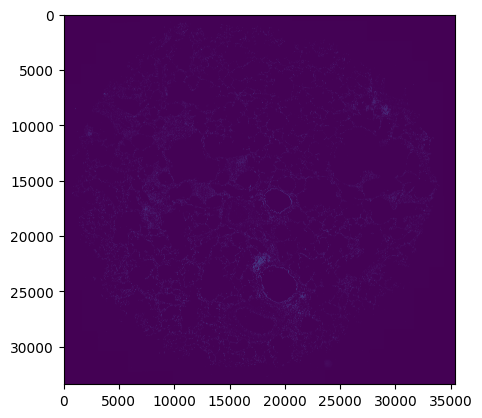

In [42]:
plt.imshow(overlaid_image[:,:,0])